In [ ]:
# Compute uvgeo from SSH
# Import necessary modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import os
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import sys
sys.path.append("/Odyssey/private/t22picar/tools")
from plot_tools import plot_uv_map, plot_map_zoom_only

lat_mask=5
depth = "15m"

file_data = f"/Odyssey/private/t22picar/data/glorys_{depth}/glorys_multivar_{depth}_2010-2018.nc"
maps = xr.open_dataset(file_data)
maps=maps.sel(time="2010-01-01")
lon_4th = maps.lon.values
lat_4th = maps.lat.values

file_data = f"/Odyssey/private/t22picar/data/glorys_{depth}/glorys_multivar_15m_2010.nc"
maps = xr.open_dataset(file_data)
maps=maps.sel(depth=maps.depth[0]).sel(time="2010-01-01")
maps = maps.rename({"latitude": "lat"})
maps = maps.rename({"longitude": "lon"})
maps

<xarray.Dataset> Size: 353MB
Dimensions:  (lat: 2041, lon: 4320)
Coordinates:
    depth    float32 4B 15.81
  * lat      (lat) float32 8kB -80.0 -79.92 -79.83 -79.75 ... 89.83 89.92 90.0
  * lon      (lon) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
    time     datetime64[ns] 8B 2010-01-01
Data variables:
    mlotst   (lat, lon) float64 71MB ...
    uo       (lat, lon) float64 71MB ...
    vo       (lat, lon) float64 71MB ...
    zos      (lat, lon) float64 71MB ...
    thetao   (lat, lon) float64 71MB ...
Attributes:
    institution:               MERCATOR OCEAN
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    Conventions:               CF-1.4
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    comment:                   CMEMS product
    title:                     daily mean fields from Global Ocean Physics An...
    copernicusmarine_version:  2.0.1

In [ ]:
ssh_test = maps.zos.values
# Get longitudes and latitudes
lon = maps.lon.values
lat = maps.lat.values
lon2D, lat2D = numpy.meshgrid(lon, lat)

def mask_data(data,lat):

    #Mask close to the equator
    data = numpy.ma.array(data, mask=((abs(lat)<lat_mask)))
    data = numpy.ma.array(data, mask=((abs(lat)<lat_mask)))

    #Mask high lat
    data = numpy.ma.array(data, mask=((abs(lat)>70)))
    data = numpy.ma.array(data, mask=((abs(lat)<-70)))

    return data


In [72]:
from jaxparrow import cyclogeostrophy, geostrophy

#(u_cyclo,v_cyclo,lat_uc, lon_uc, lat_vc, lon_vc) = cyclogeostrophy(ssh_test, lat2D, lon2D)
(u_geo,v_geo,lat_u, lon_u, lat_v, lon_v) = geostrophy(ssh_test, lat2D, lon2D)

#u_geo = mask_data(u_geo,lat_u)
#v_geo = mask_data(v_geo,lat_v)


In [ ]:
# Créer un Dataset avec les variables "u" et "v"
ds = xr.Dataset(
    {
        "u": (("time", "lat", "lon"), u_data),
        "v": (("time", "lat", "lon"), v_data),
    },
    coords={
        "time": time,
        "lat": lat,
        "lon": lon,
    }
)

In [87]:
# Créer un DataArray pour "u"
u_geo_xr = xr.DataArray(
    u_geo,
    dims=("lat", "lon"),
    coords={

        "lat": lat_u[:,0],
        "lon": lon_u[0,:],
    },
    attrs={
        "long_name": "Vitesse zonale",
        "units": "m/s",
    }
)

u_geo = u_geo_xr.interp({"lat":lat, "lon":lon}, method="linear")
u_geo_4th = u_geo_xr.interp({"lat":lat_4th, "lon":lon_4th}, method="linear")

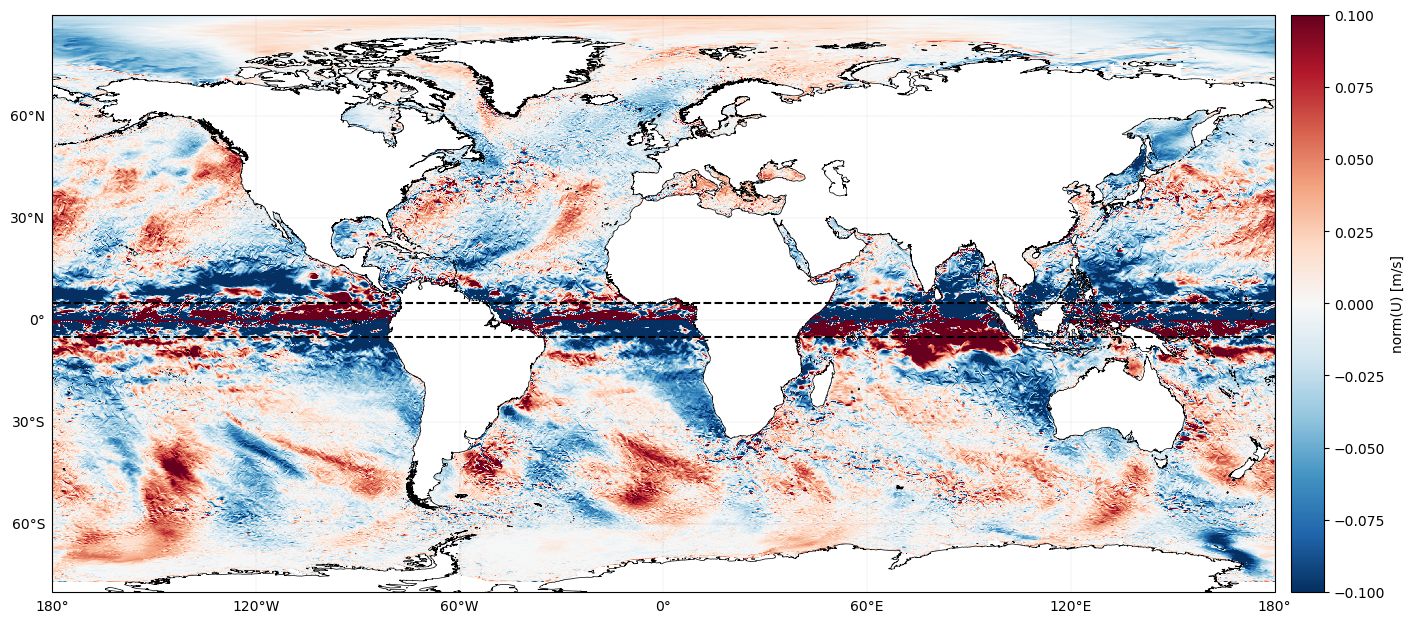

In [82]:
u_ageo = maps.uo - u_geo
plot_uv_map(u_ageo,lon,lat,vmin=-0.1,vmax=0.1)

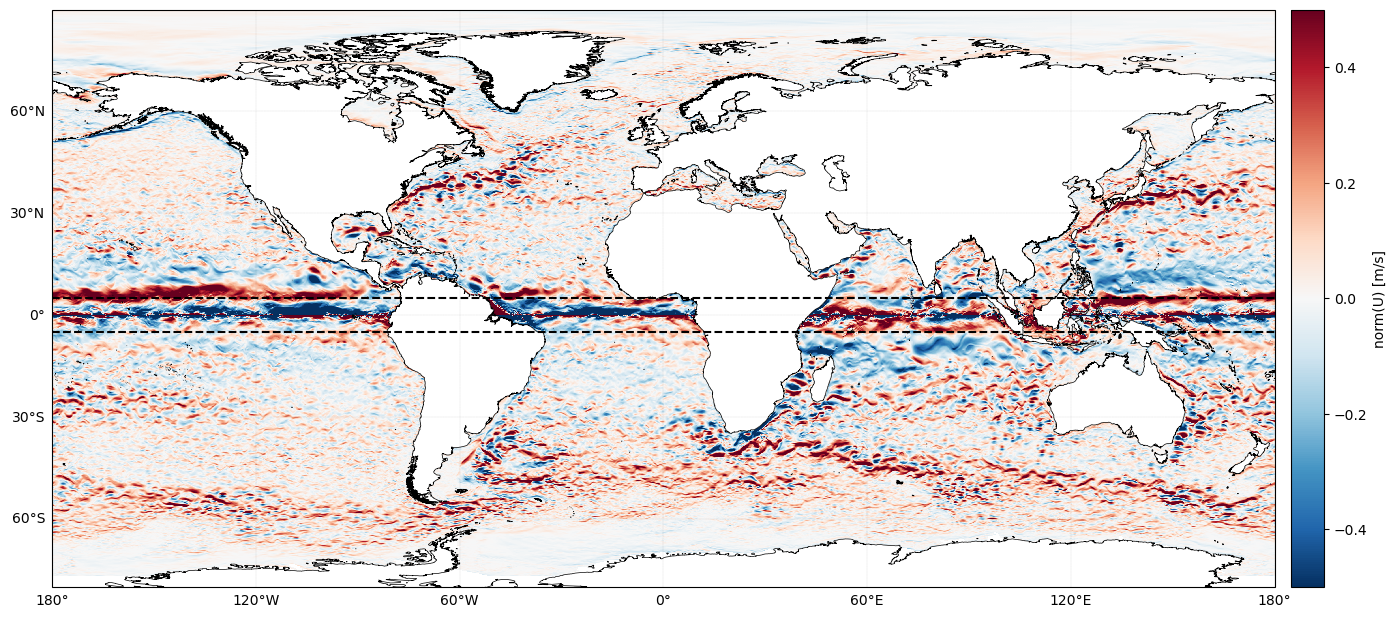

In [90]:
plot_uv_map(u_geo,lon,lat,vmin=-0.5,vmax=0.5)

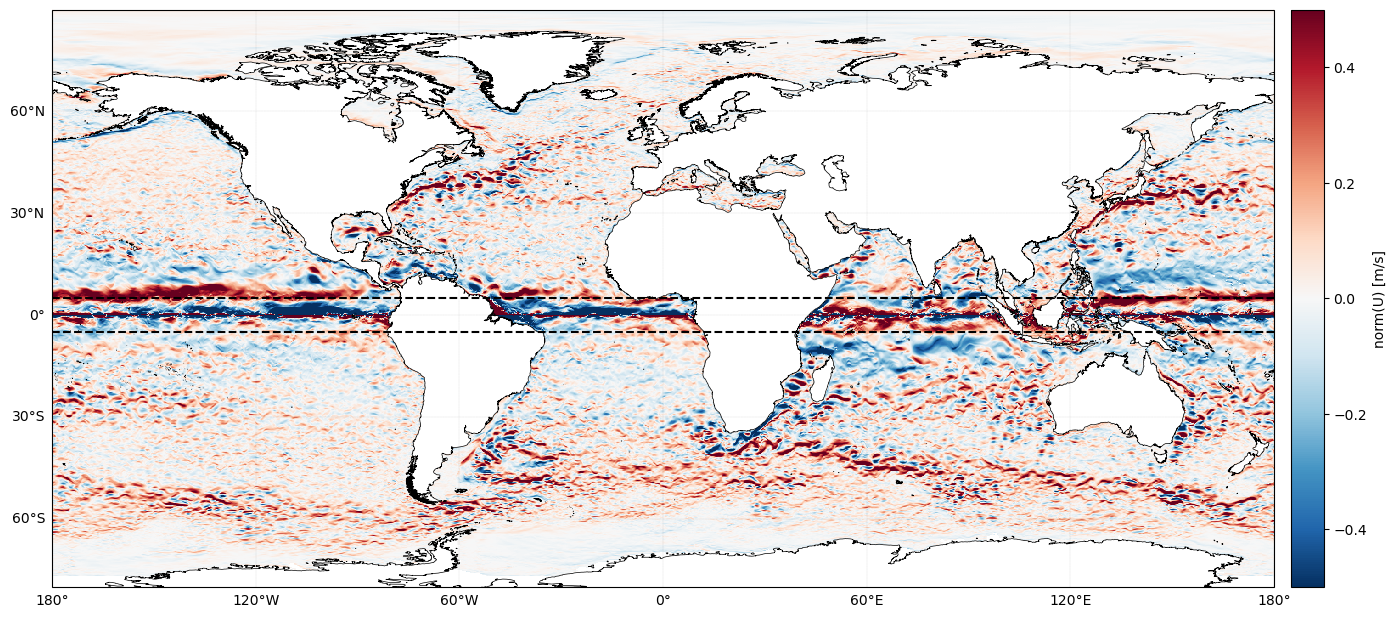

In [88]:
plot_uv_map(u_geo_4th,lon_4th,lat_4th,vmin=-0.5,vmax=0.5)

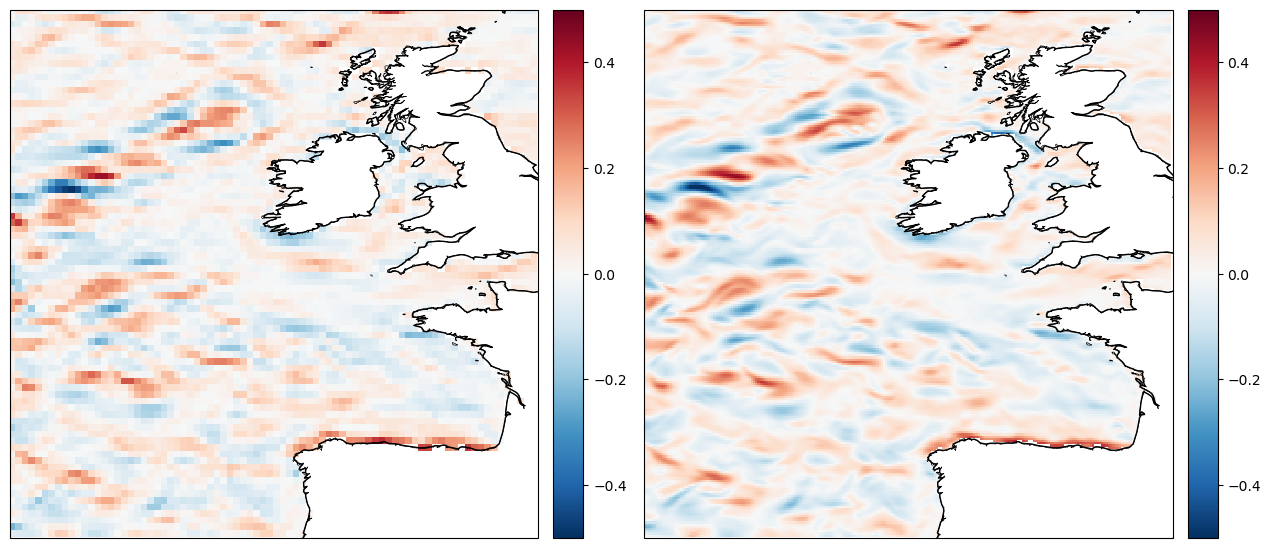

In [92]:
# Créer une figure avec trois sous-figures
#fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 ligne, 3 colonnes
import cartopy.crs as ccrs
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15*1,7.5*1))

plot_map_zoom_only(u_geo_4th,lon_4th,lat_4th,vmin=-0.5,vmax=0.5,axs=axs[0],fig=fig)

plot_map_zoom_only(u_geo,lon,lat,vmin=-0.5,vmax=0.5,axs=axs[1],fig=fig)

In [ ]:
maps

NameError: name 'maps_ageo' is not defined

In [ ]:
maps_ageo = maps.drop_vars("mlotst").drop_vars("zos").drop_vars("thetao")
maps_ageo

for time_index in range(3287):
    # Compute first time step
    (ugeo,vgeo) = compute_uvgeo(time_index) 

    uageo,vageo = maps.uo[time_index,:]-ugeo, maps.vo[time_index,:]-vgeo
    
    maps_ageo.uo.values[time_index] = uageo
    maps_ageo.vo.values[time_index] = vageo

In [106]:
from datetime import datetime, timedelta

start_date = datetime(2010, 1, 1)
end_date = datetime(2010, 1, 2)
current_date = start_date

while current_date < end_date:
    print(current_date)
    current_date += timedelta(days=1)
    file_data = f"/Odyssey/private/t22picar/data/glorys_{depth}/glorys_multivar_15m_2010.nc"
    maps = xr.open_dataset(file_data)
    maps=maps.sel(depth=maps.depth[0]).sel(time=current_date)

    #Compute geostrophy
    (u_geo,v_geo,lat_u, lon_u, lat_v, lon_v) = geostrophy(ssh_test, lat2D, lon2D)

    # Créer un Dataset avec les variables "u" et "v"
    uv_geo_xr = xr.Dataset(
        coords={
            "lat": lat_u[:,0],
            "lon": lon_u[0,:],
            "ugeo": (("lat", "lon"), u_geo),
            "vgeo": (("lat", "lon"), v_geo),
        }
    )

    # Interpolation grille d'origine
    uv_geo_xr = u_geo_xr.interp({"lat":lat, "lon":lon}, method="linear")

    uv_ageo = maps.uo.values - uv_geo_xr.ugeo
    uv_ageo = maps.uo.values - uv_geo_xr.ugeo

    # Interpolation 4th
    #u_geo_4th = u_geo_xr.interp({"lat":lat_4th, "lon":lon_4th}, method="linear")

2010-01-01 00:00:00


AttributeError: 'DataArray' object has no attribute 'ugeo'

In [110]:
    # Créer un Dataset avec les variables "u" et "v"
uv_geo_xr = xr.Dataset(
    coords={
        "lat": lat_u[:,0],
        "lon": lon_u[0,:],
        "ugeo": (("lat", "lon"), u_geo),
        "vgeo": (("lat", "lon"), v_geo),
    }
)
#uv_geo_xr = u_geo_xr.interp({"lat":lat, "lon":lon}, method="linear")
#uv_geo_xr

In [112]:
uv_geo_xr.ugeo.interp({"lat":lat, "lon":lon}, method="linear")

<xarray.DataArray 'ugeo' (lat: 2041, lon: 4320)> Size: 35MB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan, 0.03212859, 0.03212859, ..., 0.03212859, 0.03212859,
        0.03212859],
       [       nan, 0.0177268 , 0.0177268 , ..., 0.0177268 , 0.0177268 ,
        0.0177268 ],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    ugeo     (lat, lon) float32 35MB nan nan nan nan nan ... nan nan nan nan nan
    vgeo     (lat, lon) float32 35MB nan nan nan nan nan ... nan nan nan nan nan
  * lat      (lat) float32 8kB -80.0 -79.92 -79.83 -79.75 ... 89.83 89.92 90.0
  * lon      (lon) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.8 179.9

In [113]:
file_data = f"/Odyssey/private/t22picar/data/glorys_{depth}/glorys_multivar_{depth}_2010-2018.nc"
maps = xr.open_dataset(file_data)


In [ ]:
# Ajouter la variable "topo" au Dataset
maps["ugeo"] = (("time","lat", "lon"), maps.uo.values)


<xarray.Dataset> Size: 129GB
Dimensions:  (time: 3287, lat: 680, lon: 1440)
Coordinates:
    depth    float32 4B ...
  * time     (time) datetime64[ns] 26kB 2010-01-01 2010-01-02 ... 2018-12-31
  * lat      (lat) float64 5kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB -180.0 -179.7 -179.5 ... 179.4 179.7 179.9
Data variables:
    mlotst   (time, lat, lon) float64 26GB ...
    uo       (time, lat, lon) float64 26GB ...
    vo       (time, lat, lon) float64 26GB ...
    zos      (time, lat, lon) float64 26GB ...
    thetao   (time, lat, lon) float64 26GB ...
Attributes:
    institution:               MERCATOR OCEAN
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    Conventions:               CF-1.4
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    comment:                   CMEMS product
    title:                     daily mean fields from Global Ocean Physics An...
    copernicusmarine_version:  2.0.1